In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import math
from scipy.ndimage import zoom

In [2]:
class ShiftMean(nn.Module):
    # data: [t,c,h,w]
    def __init__(self, mean, std):
        super(ShiftMean, self).__init__()
        len_c = mean.shape[0]
        self.mean = torch.Tensor(mean).view(1, len_c, 1, 1)
        self.std = torch.Tensor(std).view(1, len_c, 1, 1)

    def forward(self, x, mode):
        if mode == 'sub':
            return (x - self.mean.to(x.device)) / self.std.to(x.device)
        elif mode == 'add':
            return x * self.std.to(x.device) + self.mean.to(x.device)
        else:
            raise NotImplementedError

class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feats, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feats, n_feats, kernel_size, bias=bias))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if i == 0:
                m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res


class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feats, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feats, 4 * n_feats, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn:
                    m.append(nn.BatchNorm2d(n_feats))
                if act == 'relu':
                    m.append(nn.ReLU(True))
                elif act == 'prelu':
                    m.append(nn.PReLU(n_feats))

        elif scale == 3:
            m.append(conv(n_feats, 9 * n_feats, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if act == 'relu':
                m.append(nn.ReLU(True))
            elif act == 'prelu':
                m.append(nn.PReLU(n_feats))
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)


def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)


class EDSR(nn.Module):
    def __init__(self, in_feats, n_feats, n_res_blocks, upscale_factor, mean, std, conv=default_conv):

        super(EDSR, self).__init__()

        n_resblocks = n_res_blocks # 16
        n_feats = n_feats # 64
        kernel_size = 3 
        scale = upscale_factor
        act = nn.ReLU(True)
        

        self.shift_mean = ShiftMean(torch.Tensor(mean), torch.Tensor(std)) 

        # define head module
        m_head = [conv(in_feats, n_feats, kernel_size)]

        # define body module
        m_body = [
            ResBlock(
                conv, n_feats, kernel_size, act=act, res_scale=0.1
            ) for _ in range(n_resblocks)
        ]
        m_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        m_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, in_feats, kernel_size)
        ]

        self.head = nn.Sequential(*m_head)
        self.body = nn.Sequential(*m_body)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, x):
        x = self.shift_mean(x, mode='sub')
        x = self.head(x)

        res = self.body(x)
        res += x

        x = self.tail(res)
        x = self.shift_mean(x, mode='add')

        return x 

In [4]:
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_CG = np.load(f'/pscratch/sd/h/hbassi/2d_vlasov_multi_traj_coarse_128_data.npy')[:, :]
target_FG =  np.load(f'/pscratch/sd/h/hbassi/2d_vlasov_multi_traj_fine_256_data.npy')[:, :]
input_data, output_data = torch.tensor(input_CG), torch.tensor(target_FG)
input_data.shape, output_data.shape

(torch.Size([300, 11, 128, 128]), torch.Size([300, 11, 256, 256]))

In [6]:
# Initialize model
data_mean = input_CG.mean(axis=(0, 2, 3))  # This will give you a tensor of shape (T,)
data_std  = input_CG.std(axis=(0, 2, 3))   # Also a tensor of shape (T,)
#import pdb; pdb.set_trace()
model = EDSR(11, 128, 4, 2, data_mean, data_std).to(device)
model.load_state_dict(torch.load(f'/pscratch/sd/h/hbassi/models/EDSR_2d_vlasov_multi_traj_best_model_RK_128to256.pth'))
model.eval()

EDSR(
  (shift_mean): ShiftMean()
  (head): Sequential(
    (0): Conv2d(11, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (body): Sequential(
    (0): ResBlock(
      (body): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResBlock(
      (body): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResBlock(
      (body): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): ResBlock(
      (body): Sequential(
        (0): Conv2d(128, 128, kernel_s

In [7]:
with torch.no_grad():
    pred = model(input_data.float()).squeeze(0)

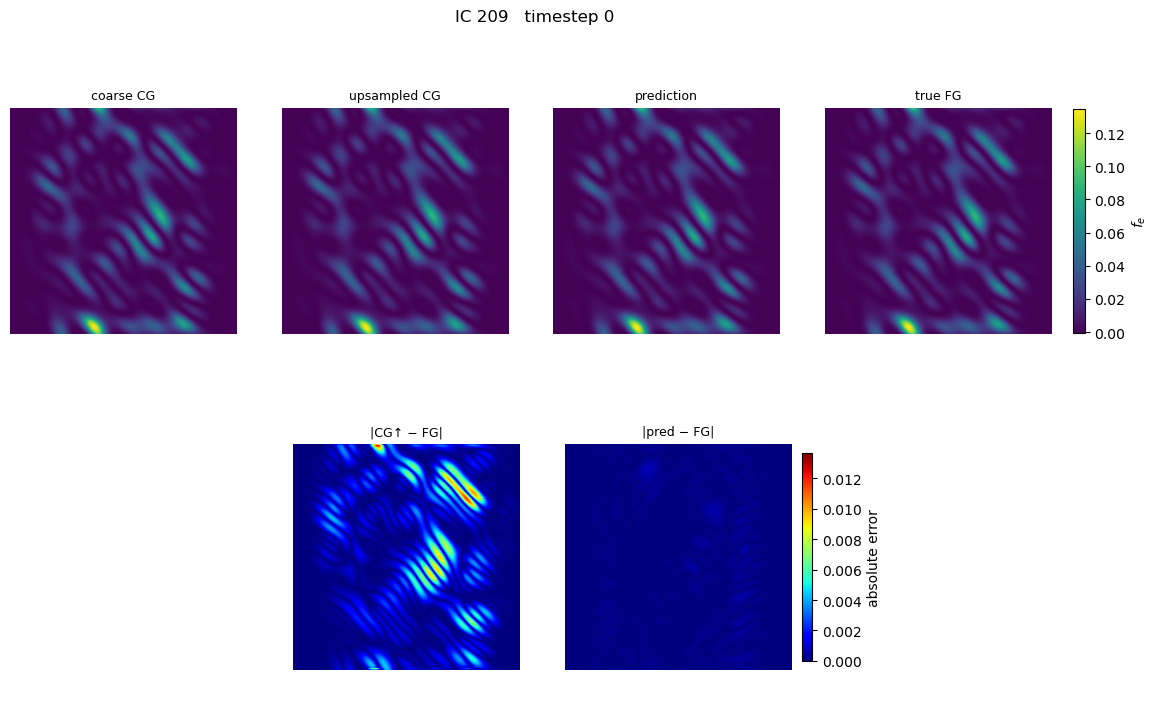

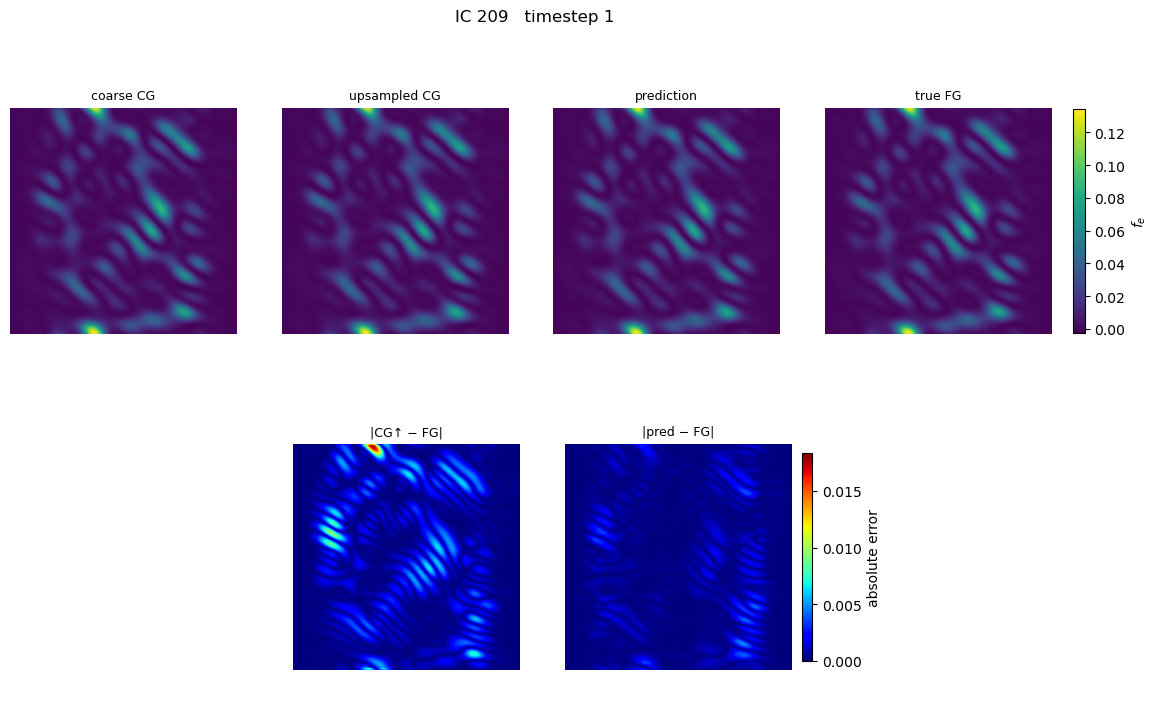

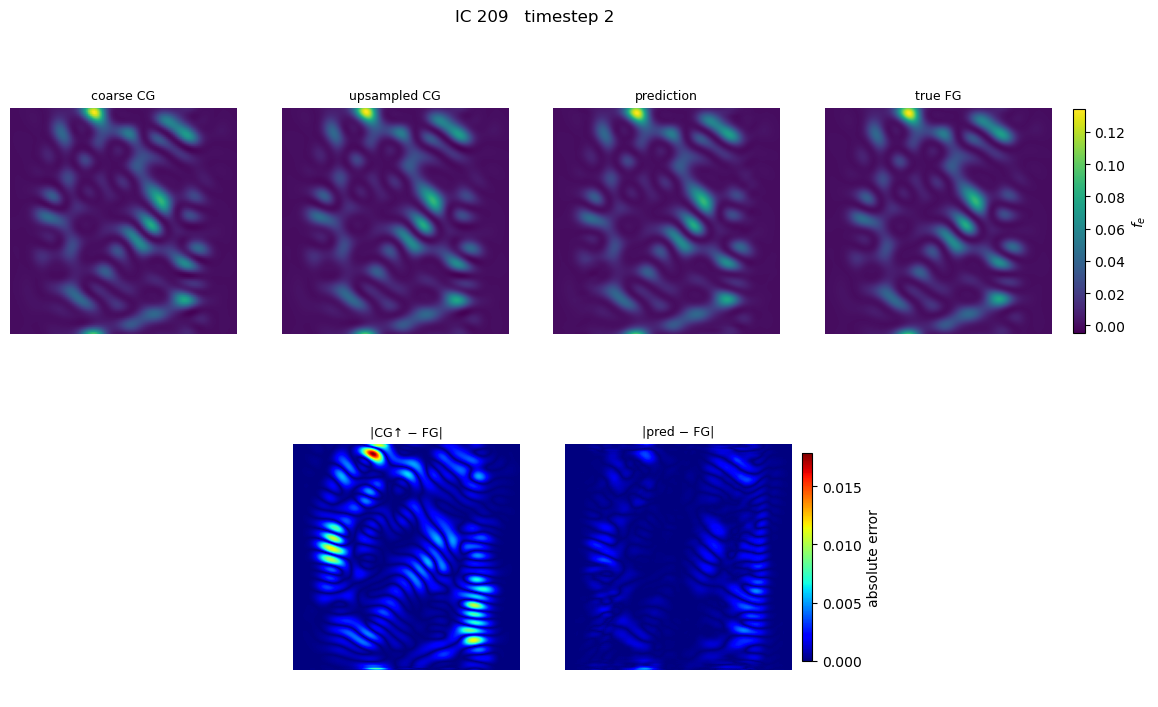

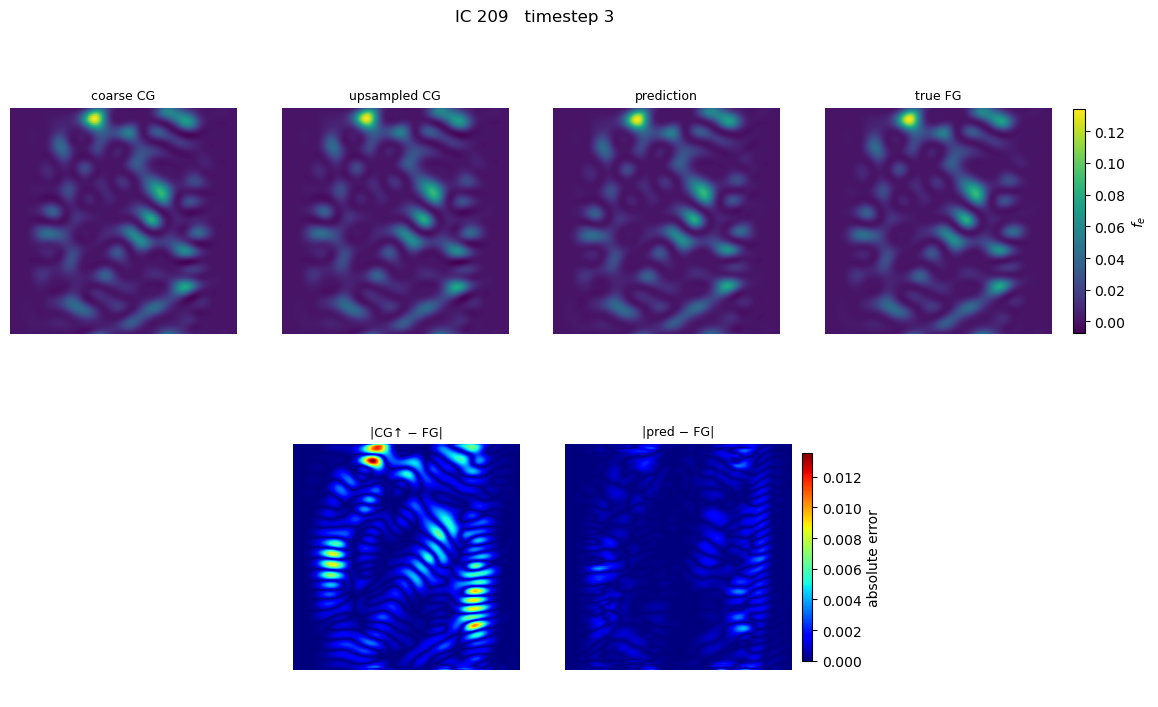

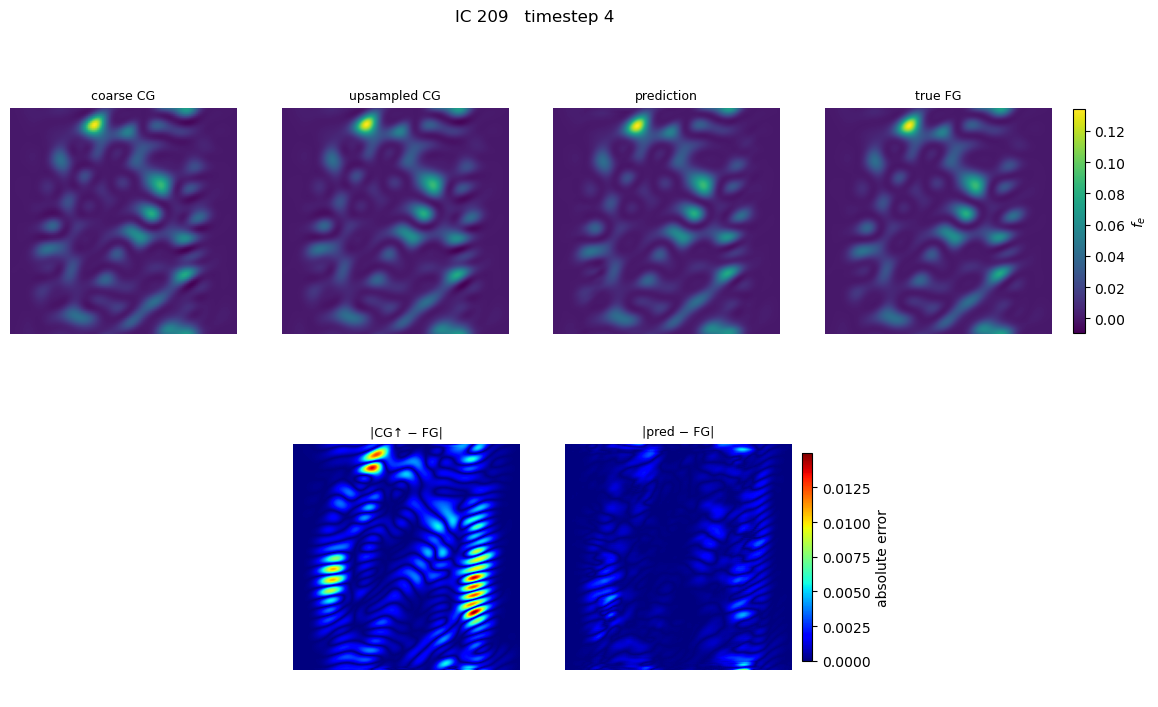

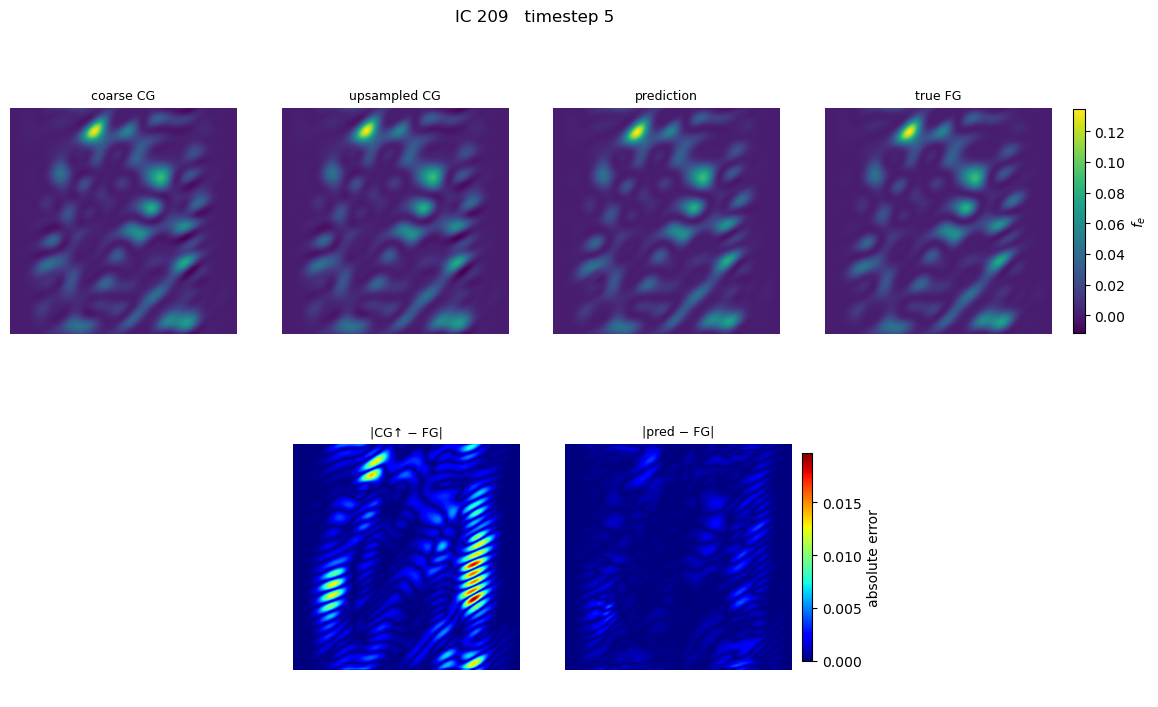

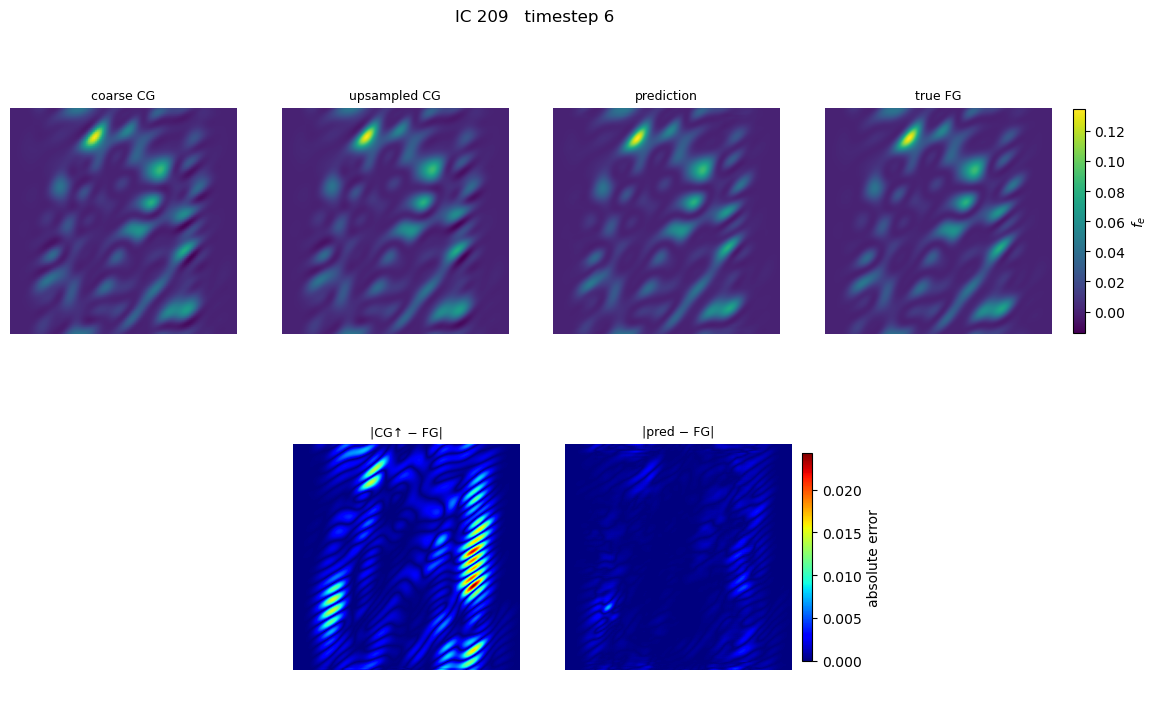

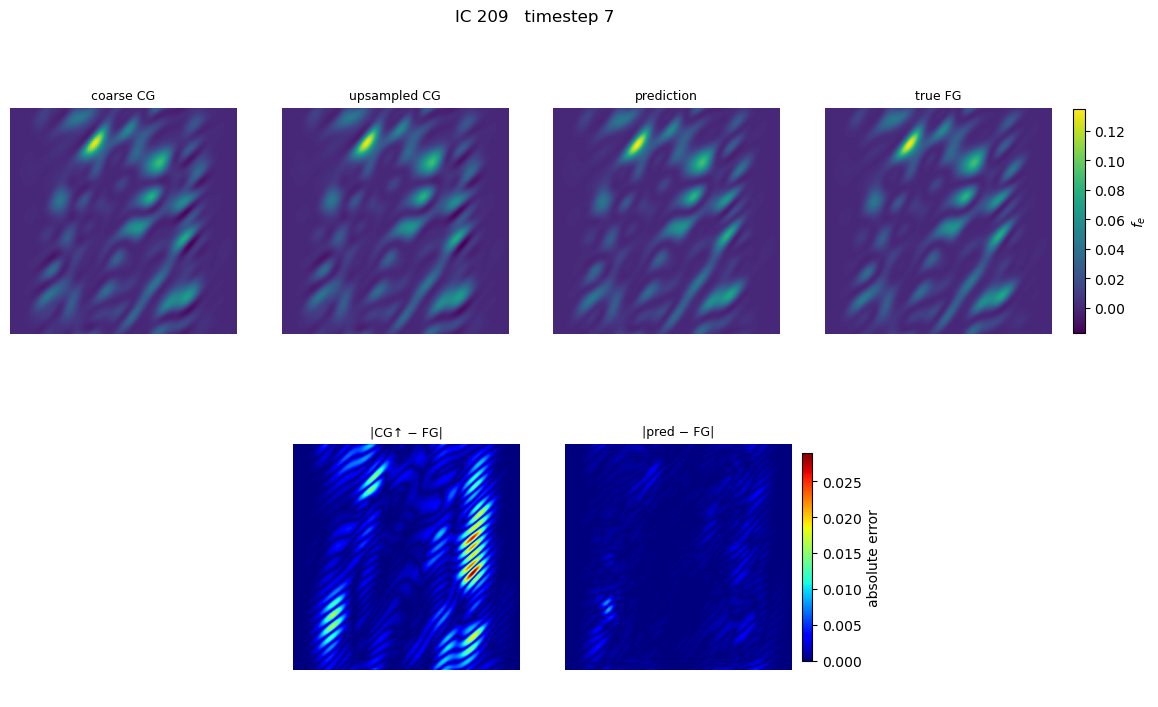

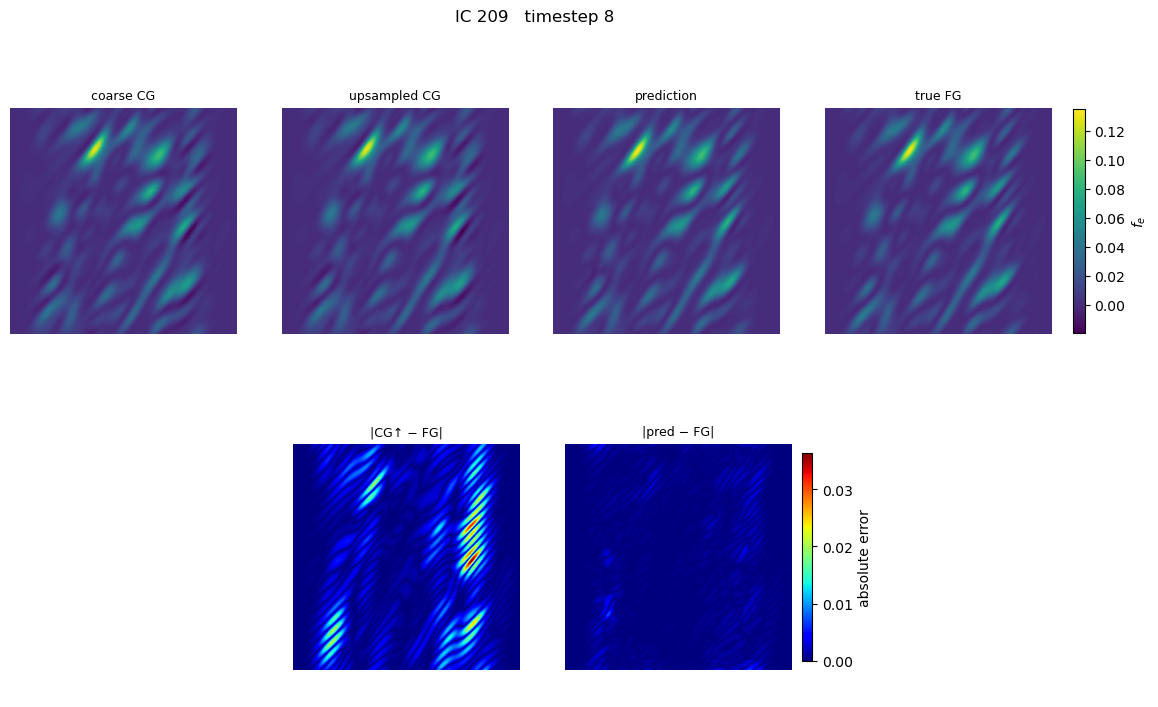

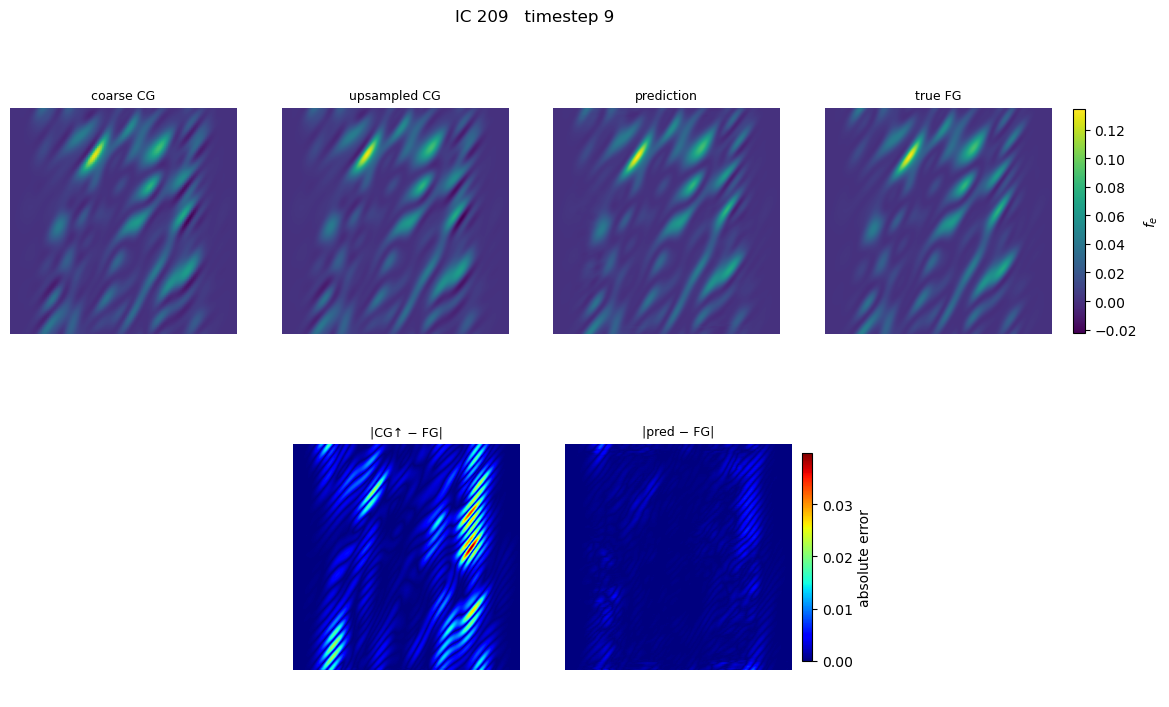

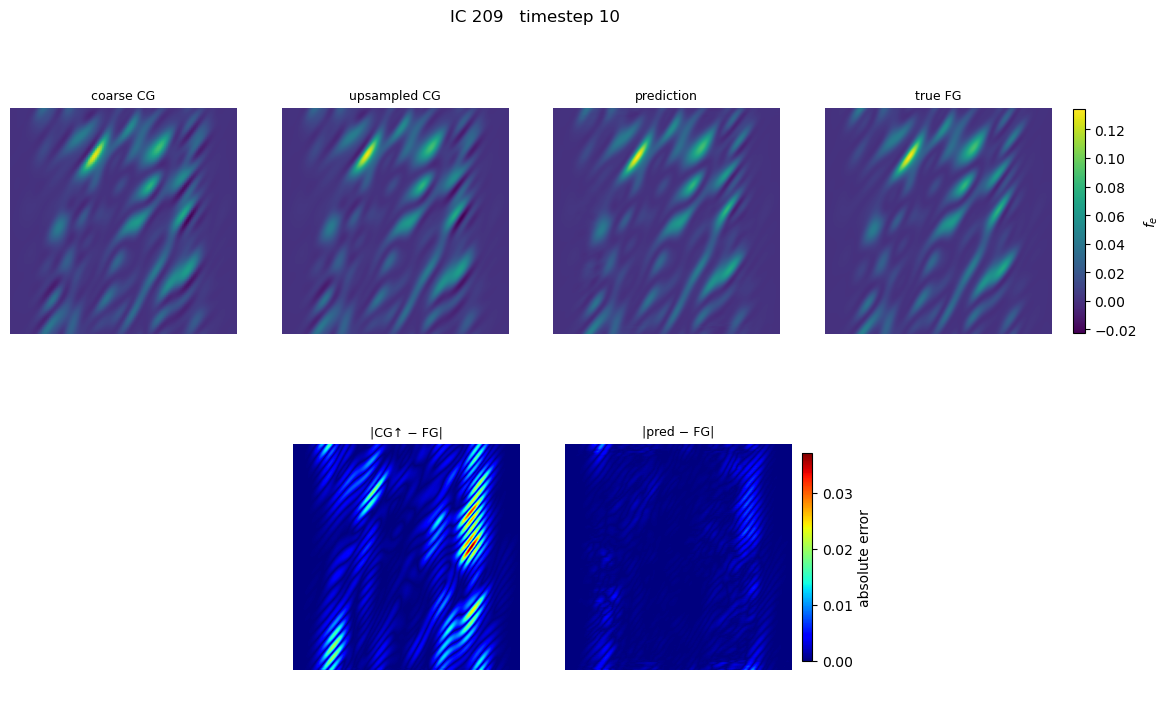

In [39]:
# ---------- automatic sizes ----------
N, Nt, Nc, _ = input_data.shape     # (N, Nt, 128, 128)
Nf           = output_data.shape[2] # 256
scale        = Nf / Nc              # 2.0

case_list = [209]                   # choose any trajectory indices

for case in case_list:
    for t in range(Nt):

        # --- data & up‑sampling -----------------------------------------
        rho_cg   = input_data [case, t]                  # 128×128
        rho_up   = zoom(rho_cg, scale, order=3)          # 256×256
        rho_pred = pred        [case, t]                 # 256×256
        rho_fine = output_data[case, t]                  # 256×256

        # --- common scale for the first‑row images ----------------------
        vmin = np.min([rho_cg.min(), rho_up.min(),
                       rho_pred.min(), rho_fine.min()])
        vmax = np.max([rho_cg.max(), rho_up.max(),
                       rho_pred.max(), rho_fine.max()])

        # --- error maps & common scale ----------------------------------
        err_up   = np.abs(rho_up   - rho_fine.cpu().detach().numpy())
        err_pred = np.abs(rho_pred - rho_fine.cpu().detach().numpy())
        err_max  = max(err_up.max(), err_pred.max())

        # --- figure with 2 rows ----------------------------------------
        fig, axes = plt.subplots(2, 4, figsize=(14, 8),
                                 gridspec_kw={'height_ratios': [1, 1]},
                                 sharex=False, sharey=False)

        # -------- first row: fields -------------------------------------
        panels = [rho_cg, rho_up, rho_pred, rho_fine]
        titles = ["coarse CG", "upsampled CG",
                  "prediction", "true FG"]
        for ax, im, ttl in zip(axes[0], panels, titles):
            h = ax.imshow(im, origin='lower', vmin=vmin, vmax=vmax)
            ax.set_title(ttl, fontsize=9)
            ax.axis('off')

        fig.colorbar(h, ax=axes[0, :], orientation='vertical',
                     fraction=0.02, pad=0.02, shrink=0.8,
                     label=r"$f_e$")

        # -------- second row: absolute errors ---------------------------
        err_axes = [axes[1, 1], axes[1, 2]]          # centre two cells
        err_imgs = [err_up, err_pred]
        err_ttl  = ["|CG↑ − FG|", "|pred − FG|"]
        for ax, im, ttl in zip(err_axes, err_imgs, err_ttl):
            h_err = ax.imshow(im, origin='lower', cmap='jet',
                              vmin=0, vmax=err_max)
            ax.set_title(ttl, fontsize=9)
            ax.axis('off')

        # blank the unused corners
        axes[1, 0].axis('off')
        axes[1, 3].axis('off')

        fig.colorbar(h_err, ax=err_axes, orientation='vertical',
                     fraction=0.02, pad=0.02, shrink=0.8,
                     label='absolute error')

        fig.suptitle(f"IC {case}   timestep {t}", y=0.97, fontsize=12)
        plt.savefig(f'./figures/vlasov_result/new_vlasov_data/EDSR/EDSR_phase1_test_fe_ic={case}_t={t}.png')
        #plt.tight_layout()
        plt.show()

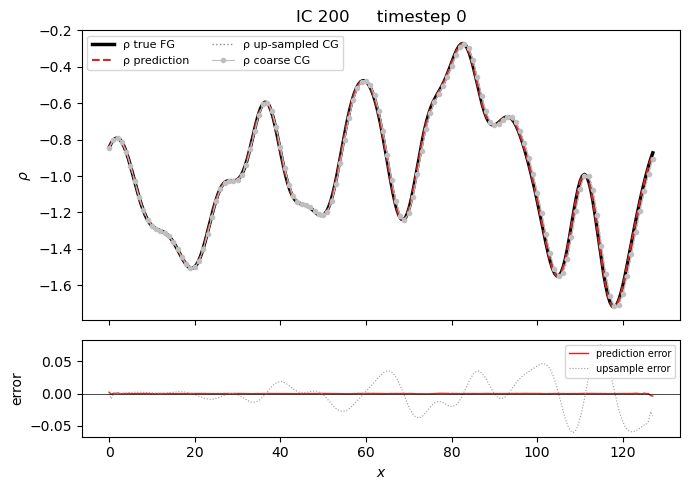

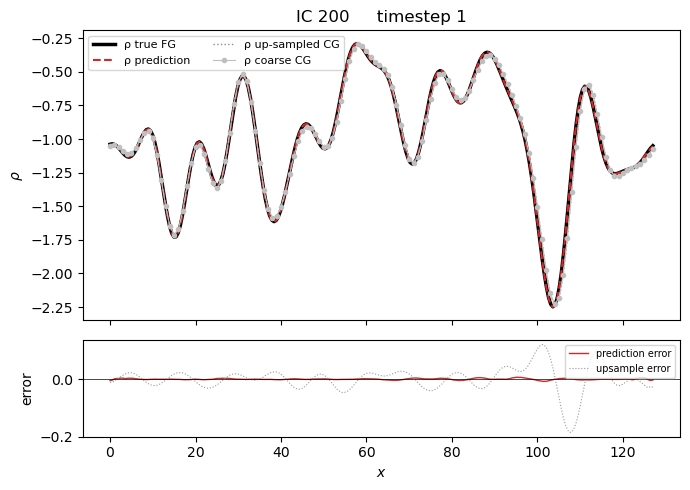

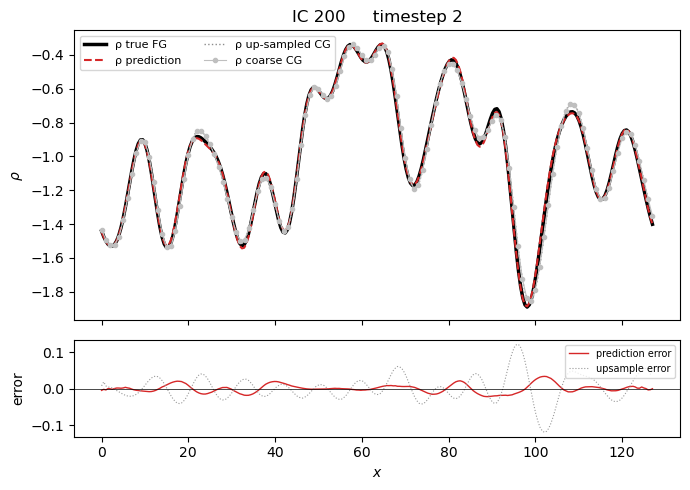

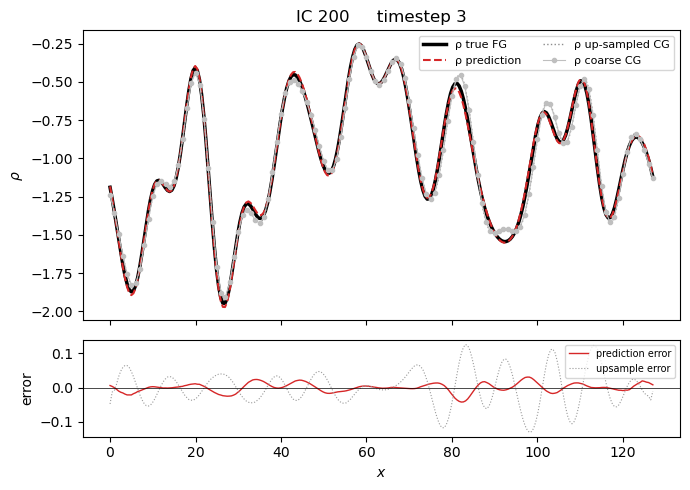

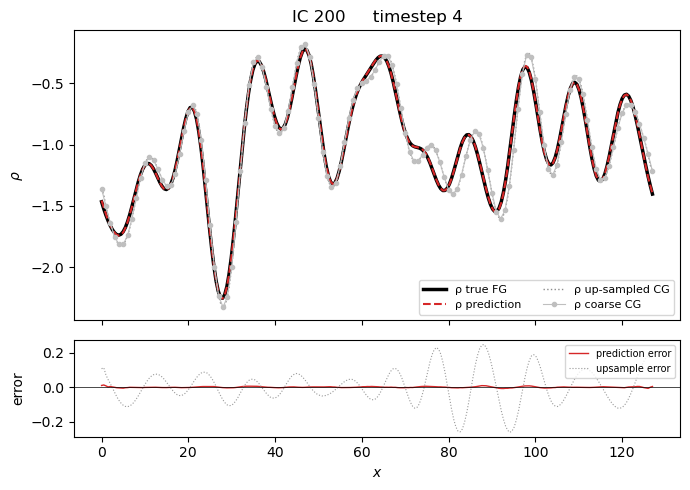

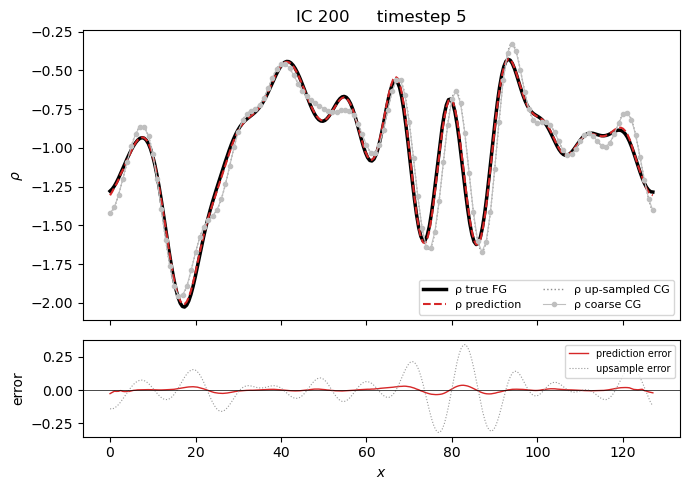

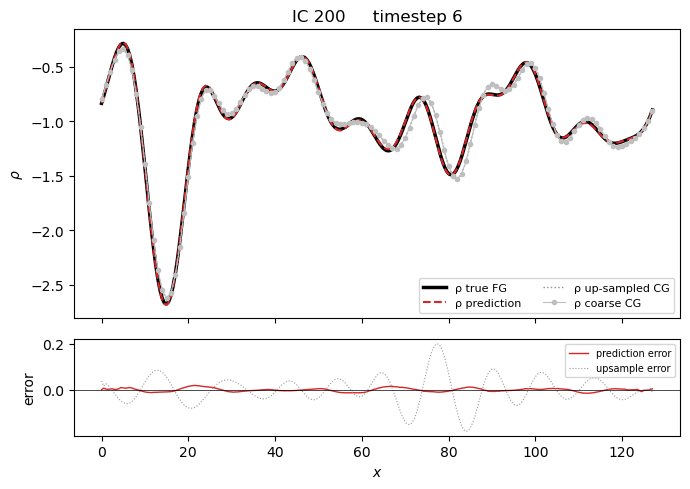

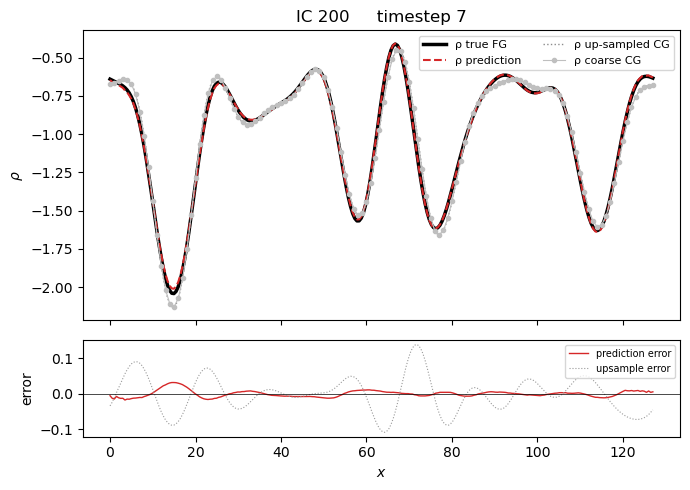

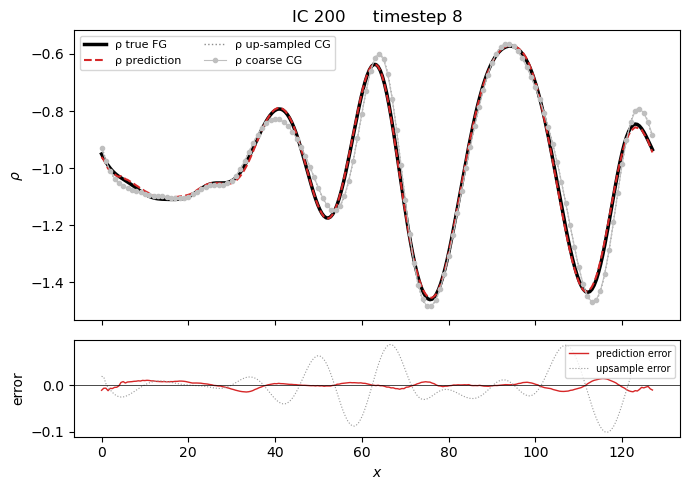

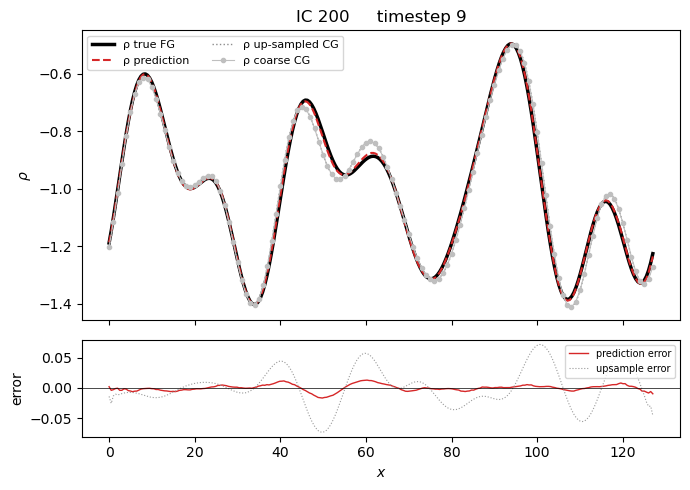

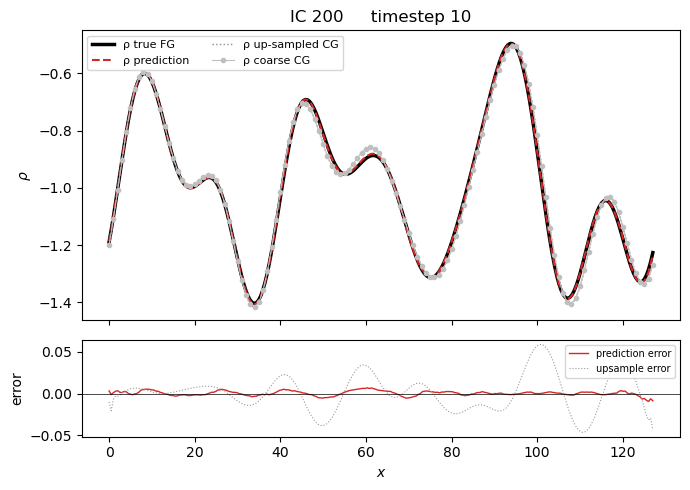

In [32]:
# -------------- constants & quick sizes ----------
qe          = -1.0
dv          = {128: 0.469*2,        # coarse grid
               256: 0.469}          # fine   grid

N, Nt, Nc, _ = input_data.shape     # Nc = 128
Nf           = output_data.shape[2] # 256
scale_x      = Nf / Nc              # 2.0  for 128→256

case_list    = list(range(200, 201))                 # or range(0, N, 10)

# -------------------------------------------------

for case in case_list:
    for t in range(Nt):

        # -------- phase‑space → charge density ρ(x) --------
        # sum over velocity (last axis) and scale by Δv
        rho_cg   = qe * input_data[case, t].sum(axis=-1) * dv[Nc]   # (128,)
        rho_fine = qe * output_data[case, t].sum(axis=-1) * dv[Nf]   # (256,)
        rho_pred = qe * pred       [case, t].sum(axis=-1) * dv[Nf]   # (256,)
        rho_fine = rho_fine.cpu().detach().numpy()
        rho_cg_up = zoom(rho_cg, zoom=scale_x, order=2)              # (256,)

        # ----------- shared x‑axis grids -----------
        x_cg   = np.arange(Nc)
        x_fine = np.linspace(0, Nc-1, Nf)

        # -------------- plotting ------------------
        # ----- main figure with residual subplot -----
        fig, (ax, axr) = plt.subplots(2, 1, figsize=(7, 5),
                                      gridspec_kw=dict(height_ratios=[3, 1]),
                                      sharex=True)
        
        # top: densities ------------------------------------------------------
        ax.plot(x_fine, rho_fine,  color='k',   lw=2.5, label='ρ true FG')
        ax.plot(x_fine, rho_pred,  color='C3',  lw=1.5, ls='--', label='ρ prediction')
        ax.plot(x_fine, rho_cg_up, color='0.55', ls=':', lw=1,  label='ρ up‑sampled CG')
        ax.plot(x_cg,   rho_cg,    color='0.75', lw=.8,  marker='o', ms=3,
                label='ρ coarse CG')
        
        ax.set_ylabel(r"$\rho$")
        ax.legend(fontsize=8, ncol=2)
        ax.set_title(f"IC {case}   timestep {t}")
        
        # bottom: residuals ---------------------------------------------------
        res_p  = rho_pred  - rho_fine
        res_cg = rho_cg_up - rho_fine
        axr.plot(x_fine, res_p,  color='C3', lw=1, label='prediction error')
        axr.plot(x_fine, res_cg, color='0.6', lw=.8, ls=':', label='upsample error')
        axr.axhline(0, color='k', lw=.5)
        axr.set_xlabel(r"$x$")
        axr.set_ylabel("error")
        axr.legend(fontsize=7, loc="upper right")
        
        plt.tight_layout()
        plt.show()


In [34]:
import torch, torch.nn as nn
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# ---------------------  MODEL DEFINITION  (unchanged) ---------------------
# ... FourierFeatureMapping, get_coord_grid, FourierLayer, ConvBlock ...
# ... SuperResUNet from your last version with dec0 stage ...

# -------------------------------------------------------------------------
#  LOAD DATA  -------------------------------------------------------------
# -------------------------------------------------------------------------
input_CG   = np.load('/pscratch/sd/h/hbassi/2d_vlasov_multi_traj_coarse_128_data.npy')
target_FG  = np.load('/pscratch/sd/h/hbassi/2d_vlasov_multi_traj_fine_256_data.npy')

input_data  = torch.tensor(input_CG,  dtype=torch.float32)          # (N, Nt, 128,128)
output_data = torch.tensor(target_FG, dtype=torch.float32)          # (N, Nt, 256,256)

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

# -------------------------------------------------------------------------
#  EVALUATE 5 CHECKPOINTS & COLLECT PREDICTIONS ---------------------------
# -------------------------------------------------------------------------
epochs = [3900, 4200, 1100, 3600, 2600]
ckpt_tmpl = '/pscratch/sd/h/hbassi/models/EDSR_2d_vlasov_multi_traj_checkpoint_epoch_{}_RK_128to256.pth'

N, Nt, Nc, _ = input_data.shape    # 128
Nf           = output_data.shape[2]# 256

pred_stack = []                    # will become (n_models,N,Nt,256,256)

with torch.no_grad():
    for ep in epochs:
        model = EDSR(11, 128, 4, 2, data_mean, data_std).to(device)
        state = torch.load(ckpt_tmpl.format(ep), map_location=device)
        model.load_state_dict(state['model_state_dict'])
        model.eval()

        # forward pass – batch all trajectories at once (fits on GPU?)
        pred = model(input_data.to(device)).cpu()    # (N,Nt,256,256)
        pred_stack.append(pred)

pred_stack = torch.stack(pred_stack)                # (5,N,Nt,256,256)
mean_pred  = pred_stack.mean(dim=0)                 # (N,Nt,256,256)
std_pred   = pred_stack.std (dim=0)                 # (N,Nt,256,256)

# -------------------------------------------------------------------------
#  CONSTANTS FOR ρ(x) -----------------------------------------------------
# -------------------------------------------------------------------------
qe   = -1.0
dv   = {128: 0.469*2, 256: 0.469}
scale_x = Nf / Nc                                     # 2.0

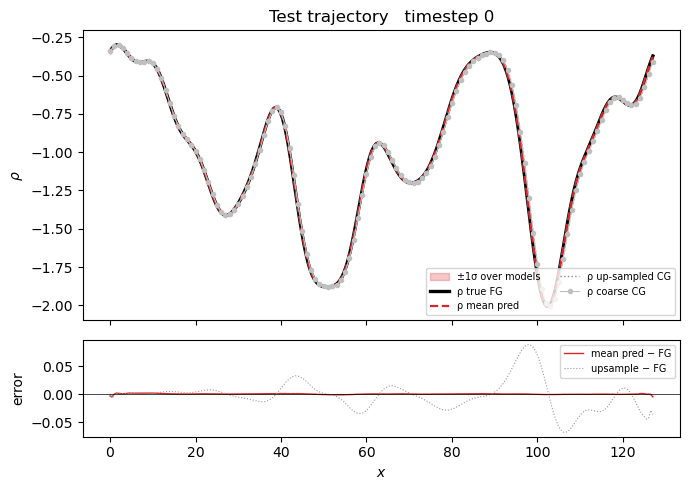

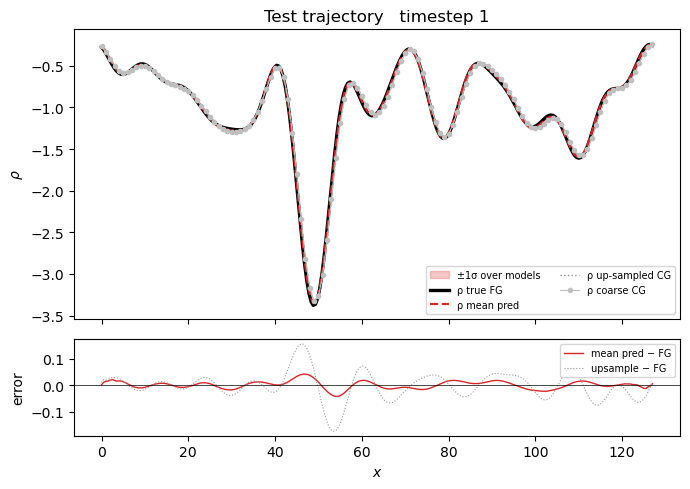

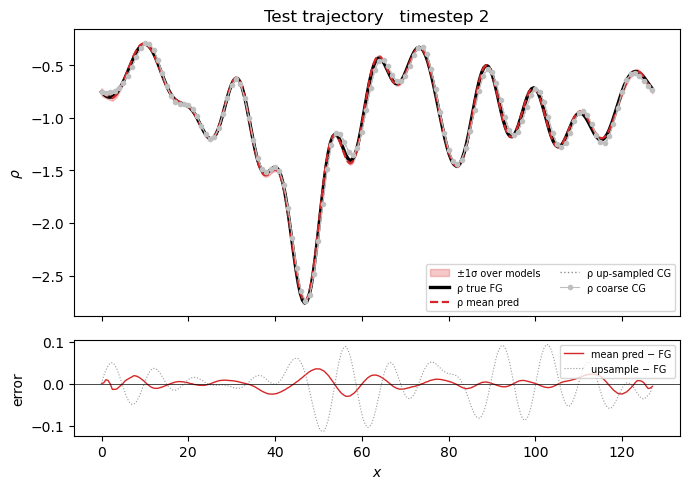

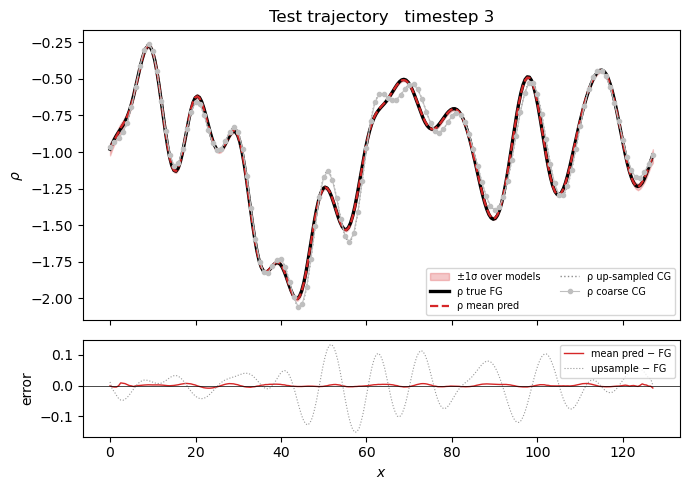

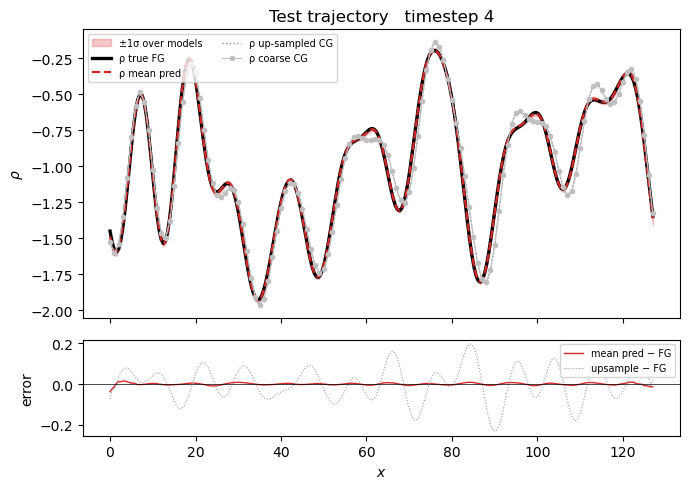

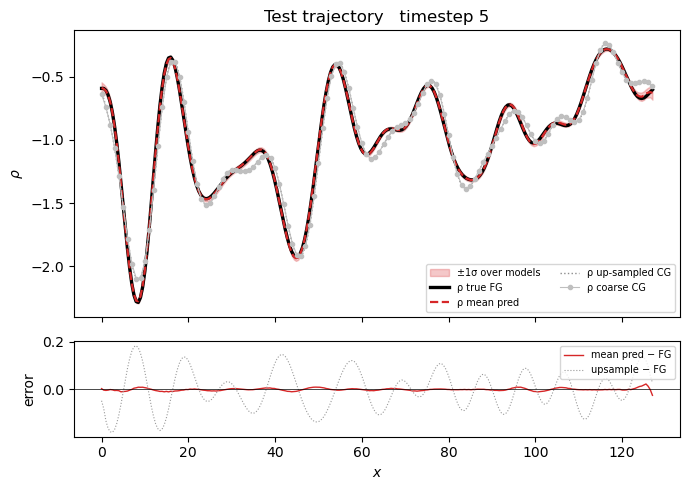

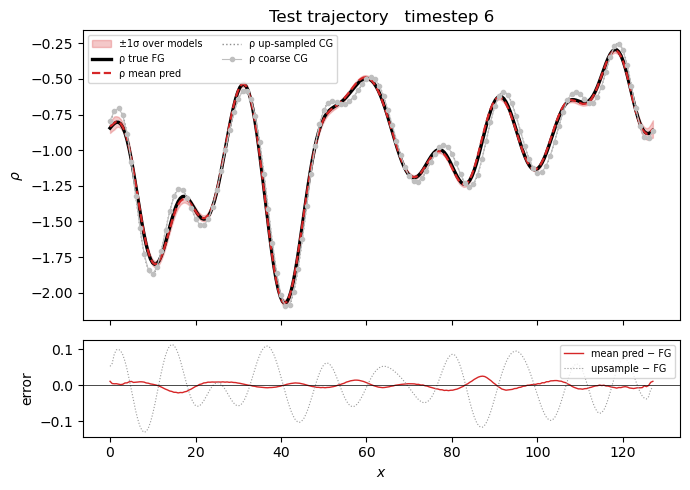

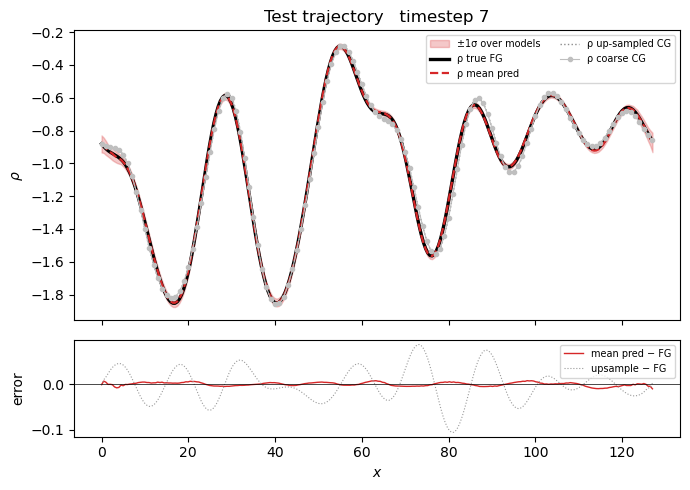

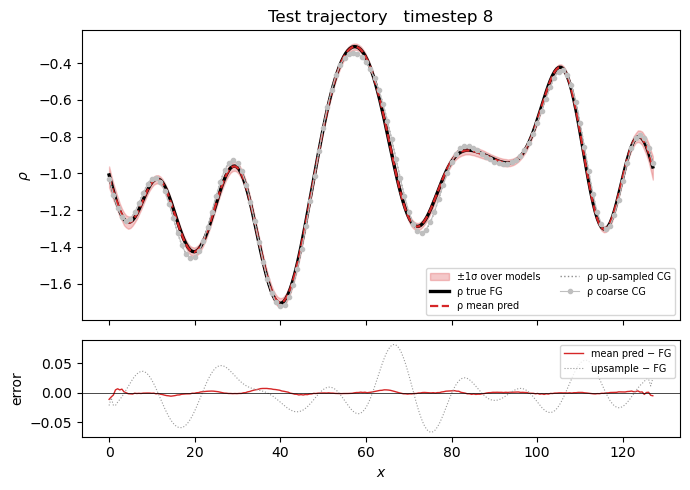

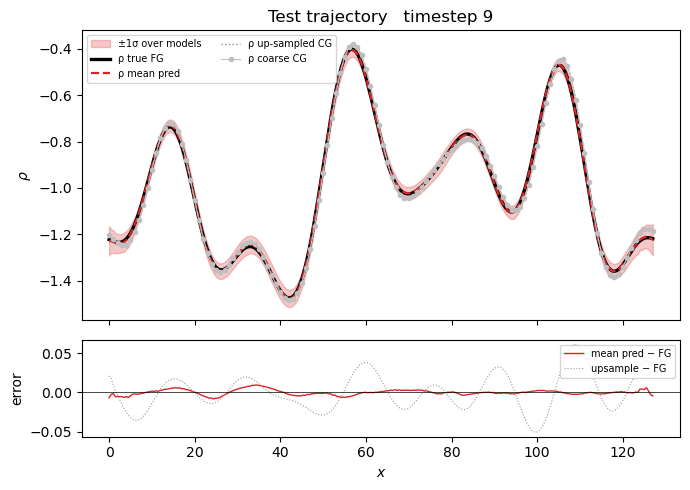

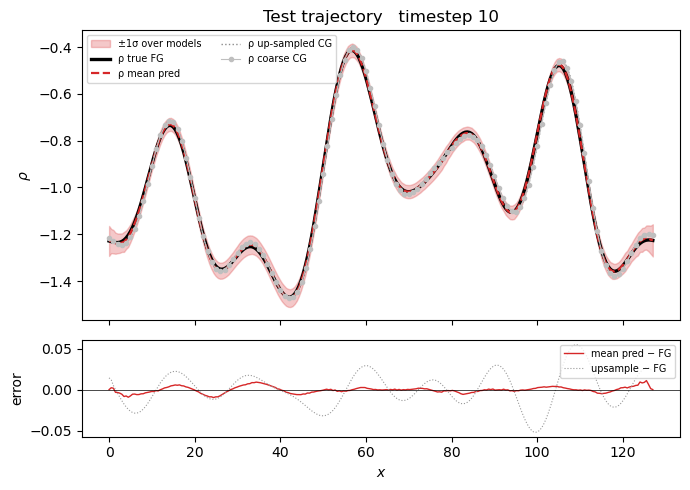

In [38]:
# -------------------------------------------------------------------------
#  PLOT ONE TRAJECTORY / ALL TIME STEPS -----------------------------------
# -------------------------------------------------------------------------
case = 220        # choose any trajectory index
for t in range(Nt):

    # ---- ρ(x) computation ------------------------------------------------
    rho_cg   = qe * input_data [case, t].sum(axis=-1) * dv[Nc]       # (128,)
    rho_up   = zoom(rho_cg, scale_x, order=2)                        # (256,)

    rho_fine = qe * output_data[case, t].sum(axis=-1) * dv[Nf]       # (256,)
    rho_mu   = qe * mean_pred [case, t].sum(axis=-1)  * dv[Nf]       # (256,)
    rho_sig  = qe * std_pred  [case, t].sum(axis=-1)   * dv[Nf]      # (256,)

    # grids
    x_cg, x_fine = np.arange(Nc), np.linspace(0, Nc-1, Nf)

    # ---- main + residual figure -----------------------------------------
    fig, (ax, axr) = plt.subplots(2, 1, figsize=(7, 5),
                                  gridspec_kw=dict(height_ratios=[3, 1]),
                                  sharex=True)

    # top panel ------------------------------------------------------------
    ax.fill_between(x_fine, rho_mu-rho_sig, rho_mu+rho_sig,
                    color='C3', alpha=.25, label='±1σ over models')
    ax.plot(x_fine, rho_fine, color='k',  lw=2.4, label='ρ true FG')
    ax.plot(x_fine, rho_mu,  color='C3', lw=1.6, ls='--', label='ρ mean pred')
    ax.plot(x_fine, rho_up,  color='0.55', ls=':', lw=1, label='ρ up‑sampled CG')
    ax.plot(x_cg, rho_cg,   color='0.75', lw=.8, marker='o', ms=3,
            label='ρ coarse CG')

    ax.set_ylabel(r"$\rho$")
    ax.legend(fontsize=7, ncol=2)
    ax.set_title(f"Test trajectory   timestep {t}")

    # residual panel -------------------------------------------------------
    axr.plot(x_fine, rho_mu - rho_fine,  color='C3', lw=1,
             label='mean pred − FG')
    axr.plot(x_fine, rho_up - rho_fine.cpu().detach().numpy(), color='0.6', ls=':', lw=.8,
             label='upsample − FG')
    axr.axhline(0, color='k', lw=.5)
    axr.set_xlabel(r"$x$")
    axr.set_ylabel("error")
    axr.legend(fontsize=7, loc="upper right")

    plt.tight_layout()
    plt.savefig(f'./figures/vlasov_result/new_vlasov_data/EDSR/EDSR_phase1_test_charge_density_ic={case}_t={t}.png')
    plt.show()